In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pylab as plt

# generate random data

In [2]:
def gen_random_data(num_total=5000):
    num_cats = int(num_total * 0.4)
    num_dogs = int(num_total * 0.6)

    cats = [
            abs(np.random.randn(num_cats) * 2 + 34),
            abs(np.random.randn(num_cats) * 1 + 8)
    ]

    dogs = [
            abs(np.random.randn(num_dogs) * 20 + 50),
            abs(np.random.randn(num_dogs) * 20 + 30)
    ]

    X = np.concatenate([np.array(cats), np.array(dogs)], axis=1).T
    Y = np.array([0] * num_cats + [1] * num_dogs).astype(np.uint)

    Y_one_hot = np.zeros((Y.shape[0], 2), dtype=np.float)
    Y_one_hot[Y == 0, 0] = 1
    Y_one_hot[Y == 1, 1] = 1
    return X, Y, Y_one_hot
    
    

training_X, training_Y, training_Y_one_hot = gen_random_data(5000)
validation_X, validation_Y, validation_Y_one_hot = gen_random_data(500)
test_X, test_Y, test_Y_one_hot = gen_random_data(1000)

num_training_samples = training_X.shape[0]
num_validation_samples = validation_X.shape[0]

# display data

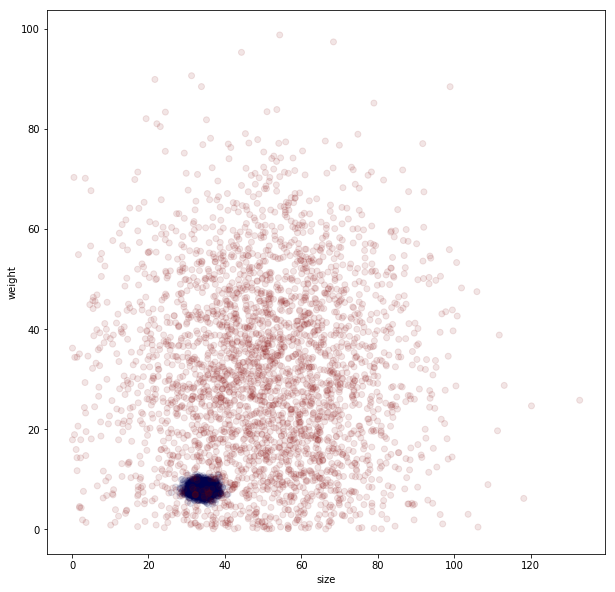

In [3]:
plt.figure(figsize=(10,10))
plt.scatter(training_X[:,0], training_X[:,1], c=training_Y, cmap=plt.cm.seismic, alpha=0.1)
plt.xlabel("size")
plt.ylabel("weight");

# train simple linear regression

In [4]:
learning_rate = 0.01

g = tf.Graph()
with g.as_default():
    
    X = tf.placeholder(tf.float32, shape=[None, 2], name="X")
    Y_true = tf.placeholder(tf.float32, shape=[None, 2], name="Y_true")    
    
    # simple linear regression
    W = tf.Variable(tf.random_normal([2, 2], stddev=0.35), name="weights")
    B = tf.Variable(tf.zeros([2]), name="biases")        
    Y = tf.add(tf.matmul(X, W), B)
    
    
    # add 10 hidden neurons
    #W_h = tf.Variable(tf.random_normal([2, 10], stddev=0.35), name="weights_hidden")
    #B_h = tf.Variable(tf.zeros([10]), name="biases_hidden")        
    #H = tf.add(tf.matmul(X, W_h), B_h)
    ##[spoiler] forgot non linearity [/spoiler]
    ##H = tf.nn.relu(tf.add(tf.matmul(X, W_h), B_h))
    
    #W_out = tf.Variable(tf.random_normal([10, 2], stddev=0.35), name="weights_out")
    #B_out = tf.Variable(tf.zeros([2]), name="biases_out")        
    #Y = tf.add(tf.matmul(H, W_out), B_out)

    
    # add softmax
    Y_pred = tf.nn.softmax(Y, name="Y_pred")        
    
    # define loss, note: it's defined on Y not Y_pred
    loss = tf.losses.softmax_cross_entropy(Y_true, Y)
    
    # this will init the variables (with either random values or zeros)
    init = tf.global_variables_initializer()    
    
    # define the optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    # ... and tell it what to minimize
    minimize = optimizer.minimize(loss)
    
    # util class for saving and loading models
    saver = tf.train.Saver()
    
    losses = []
    with tf.Session() as sess:
        sess.run(init)        
        
        for epoch in range(10000):
            batch = np.random.choice(num_training_samples, (10,))
            sess.run(minimize, feed_dict={X:training_X[batch,:], Y_true: training_Y_one_hot[batch,:]})
                        
            if epoch % 100 == 0:
                # evaluate validation loss and store it
                batch = np.random.choice(num_validation_samples, (10,))        
                current_loss = sess.run(loss, feed_dict={X:validation_X[batch,:], Y_true: validation_Y_one_hot[batch,:]})                                
                losses.append(current_loss)
                
                # note: don't really do it this way, that is for demonstration purposes
                # have a look at tf.summary.scalar(..) and Tensorfboard

        # store the model and the weights to disk
        saver.save(sess, "cat_vs_dog.ckpt")
                
            
plt.plot(losses)            

AttributeError: 'module' object has no attribute 'placeholder'

# load and test model

In [ ]:
# this defines a new graph (so it could be a different program, etc.)
g = tf.Graph()

with g.as_default():
    
    # load the graph definition (i.e. what variables, placeholders, etc exist)
    loader = tf.train.import_meta_graph('cat_vs_dog.ckpt.meta')
    
    # fetch the input and output placeholders
    X = g.get_tensor_by_name("X:0")
    Y_pred = g.get_tensor_by_name("Y_pred:0")
    # note the :0, you can find a good explanation why that is needed here:
    # https://stackoverflow.com/questions/37849322/how-to-understand-the-term-tensor-in-tensorflow/37870634#37870634
        
    with tf.Session() as sess:
        # load the values for all variables
        loader.restore(sess, "cat_vs_dog.ckpt")                
        
        # compute the prediction for a single example        
        y_pred = sess.run(Y_pred, feed_dict={X:[ [100, 40] ]})
        print("cat %0.3f, dog %0.3f" % tuple(y_pred[0]))
        
        # get the predictions for our whole test data set
        Y_test_pred_one_hot = sess.run(Y_pred, feed_dict={X:test_X})
        # ...and compute the accuracy
        Y_test_pred = np.argmax(Y_test_pred_one_hot, axis=1)        
        accuracy = np.mean(Y_test_pred == test_Y)
        print("accuracy: %0.3f" % accuracy)
                
        # densly sample feature space
        sizes, weights = np.meshgrid(np.linspace(0, 120, 50), np.linspace(0, 100, 50))
        X_grid = np.stack([sizes.flatten(), weights.flatten()]).T
        Y_grid = sess.run(Y_pred, feed_dict={X:X_grid})        
        Y_grid = Y_grid.reshape((50, 50,2))            

# plot decission boundary

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(Y_grid[:,:,1], cmap=plt.cm.seismic, alpha=0.1, extent=(0,120,100,0))
plt.scatter(test_X[:,0], test_X[:,1], c=test_Y, cmap=plt.cm.seismic, alpha=0.1)
plt.xlabel("size")
plt.ylabel("weight");

# evaluate results

scikit-learn (package name sklearn) has a set of utility functions for computing evaluation metrics

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score

print("confusion_matrix\n", confusion_matrix(test_Y, Y_test_pred))
print("accuracy_score : ", accuracy_score(test_Y, Y_test_pred))

fpr, tpr, thresholds = roc_curve(test_Y, Y_test_pred_one_hot[:,1])
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,10))
plt.title('AUC = %0.2f' % (roc_auc))
plt.plot(fpr, tpr)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');